In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pickle
import numpy as np
import librosa
import keras
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
SAMPLE_RATE = 22050
N_FFT = 2048 #int(0.025 * SAMPLE_RATE)  # 25ms frame length
WIN_LENGTH = int(0.025 * SAMPLE_RATE)
HOP_LENGTH = 512 #int(0.010 * SAMPLE_RATE)     # 10ms hop length
N_MFCC = 20  # Number of cepstral coefficients to be extracted
N_MELS =40
DURATION = 30  # Duration of each audio file
NUM_SEGMENTS = 10  # Number of segments per audio file

In [4]:
file_path = "/content/drive/MyDrive/preprocess.pkl"

# Load data from pickle file
with open(file_path, "rb") as f:
    data = pickle.load(f)

In [5]:
def mfcc(audio) :
  mfcc = librosa.feature.mfcc(y=audio, sr=SAMPLE_RATE, n_mfcc=N_MFCC, n_fft=N_FFT, hop_length=HOP_LENGTH)

  delta_mfcc = librosa.feature.delta(mfcc)
  delta2_mfcc = librosa.feature.delta(mfcc, order=2)
  concanated_mfcc = np.vstack((mfcc, delta_mfcc, delta2_mfcc))
  concanated_mfcc = concanated_mfcc.T
  return concanated_mfcc.tolist()


In [6]:
X_train = []
y_train = []
X_val = []
y_val = []
X_test = []
y_test = []

for i in range(len(data["train"]["features"])) :
    feature = data["train"]["features"][i]
    label = data["train"]["labels"][i]

    extraction = mfcc(feature)

    X_train.append(extraction)
    y_train.append(label)

for i in range(len(data["val"]["features"])) :
    feature = data["val"]["features"][i]
    label = data["val"]["labels"][i]

    extraction = mfcc(feature)

    X_val.append(extraction)
    y_val.append(label)

for i in range(len(data["test"]["features"])) :
    feature = data["test"]["features"][i]
    label = data["test"]["labels"][i]

    extraction = mfcc(feature)

    X_test.append(extraction)
    y_test.append(label)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
X_test = np.array(X_test)
y_test = np.array(y_test)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)


(5832, 130, 60)
(729, 130, 60)
(729, 130, 60)


In [7]:
def build_model(input_shape):
    model = keras.Sequential()

    # First Bidirectional LSTM layer
    model.add(keras.layers.Bidirectional(keras.layers.LSTM(512, return_sequences=True), input_shape=input_shape))
    model.add(keras.layers.LayerNormalization())  # Tambahkan Layer Normalization di sini
    # model.add(keras.layers.Bidirectional(keras.layers.LSTM(512, return_sequences=True)))
    # model.add(keras.layers.LayerNormalization())  # Dan juga di sini

    # Global Average Pooling layer (or Global Max Pooling)
    model.add(keras.layers.GlobalAveragePooling1D())

    # Output layer
    model.add(keras.layers.Dense(8, activation="softmax"))

    return model

In [8]:
def plot_history(history):

        fig, axs = plt.subplots(2)

        # create accuracy subplot
        axs[0].plot(history.history["accuracy"], label="train accuracy")
        axs[0].plot(history.history["val_accuracy"], label="test accuracy")
        axs[0].set_ylabel("Accuracy")
        axs[0].legend(loc="lower right")
        axs[0].set_title("Accuracy eval")

        # margin top
        fig.subplots_adjust(top=1.4, bottom=0.1, left=0.10, right=0.95)

        # create error subplot
        axs[1].plot(history.history["loss"], label="train error")
        axs[1].plot(history.history["val_loss"], label="test error")
        axs[1].set_ylabel("Error")
        axs[1].set_xlabel("Epoch")
        axs[1].legend(loc="upper right")
        axs[1].set_title("Error eval")

        plt.show()


In [9]:
input_shape = (X_train.shape[1], X_train.shape[2])
model = build_model(input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 130, 1024)         2347008   
 al)                                                             
                                                                 
 layer_normalization (Layer  (None, 130, 1024)         2048      
 Normalization)                                                  
                                                                 
 global_average_pooling1d (  (None, 1024)              0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 8)                 8200      
                                                                 
Total params: 2357256 (8.99 MB)
Trainable params: 2357256 (8.99 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [10]:

# compile model
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# add callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = keras.callbacks.ModelCheckpoint(filepath='/content/models/ismir.h5', save_best_only=True)

# train model
history = model.fit(X_train, y_train, validation_data=(X_val,y_val), batch_size=128, epochs=30, callbacks=[early_stopping, model_checkpoint])

Epoch 1/30
46/46 [==============================] - 15s 120ms/step - loss: 0.8761 - accuracy: 0.6941 - val_loss: 0.6648 - val_accuracy: 0.7682
Epoch 2/30
 1/46 [..............................] - ETA: 3s - loss: 0.6378 - accuracy: 0.7578

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - 5s 104ms/step - loss: 0.4616 - accuracy: 0.8318 - val_loss: 0.4687 - val_accuracy: 0.8450
Epoch 3/30
46/46 [==============================] - 5s 100ms/step - loss: 0.3057 - accuracy: 0.8995 - val_loss: 0.3747 - val_accuracy: 0.8807
Epoch 4/30
46/46 [==============================] - 5s 100ms/step - loss: 0.1943 - accuracy: 0.9422 - val_loss: 0.2845 - val_accuracy: 0.9108
Epoch 5/30
46/46 [==============================] - 5s 105ms/step - loss: 0.1260 - accuracy: 0.9671 - val_loss: 0.2421 - val_accuracy: 0.9204
Epoch 6/30
46/46 [==============================] - 5s 103ms/step - loss: 0.0832 - accuracy: 0.9793 - val_loss: 0.2123 - val_accuracy: 0.9328
Epoch 7/30
46/46 [==============================] - 5s 101ms/step - loss: 0.0580 - accuracy: 0.9863 - val_loss: 0.2160 - val_accuracy: 0.9232
Epoch 8/30
46/46 [==============================] - 5s 104ms/step - loss: 0.0386 - accuracy: 0.9909 - val_loss: 0.2218 - val_accuracy: 0.9232
Epoch 9/30
46/46 

23/23 [==============================] - 0s 16ms/step - loss: 0.2645 - accuracy: 0.9369
Train accuracy: 100.00%
Train loss:  0.04%
Validation accuracy: 94.79%
Validation loss: 18.18%
Test accuracy: 93.69%
Test loss: 26.45%


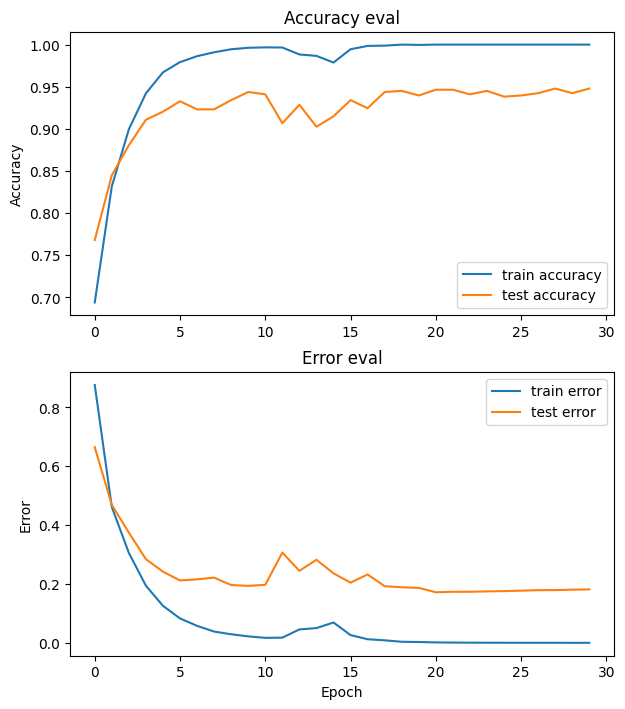

In [11]:
# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
print("Train accuracy: {:5.2f}%".format(100 * train_acc[-1]))
print("Train loss: {:5.2f}%".format(100 * train_loss[-1]))
print("Validation accuracy: {:5.2f}%".format(100 * val_acc[-1]))
print("Validation loss: {:5.2f}%".format(100 * val_loss[-1]))
print("Test accuracy: {:5.2f}%".format(100 * test_acc))
print("Test loss: {:5.2f}%".format(100 * test_loss))
plot_history(history)

23/23 [==============================] - 1s 19ms/step
Confusion Matrix:


<Axes: >

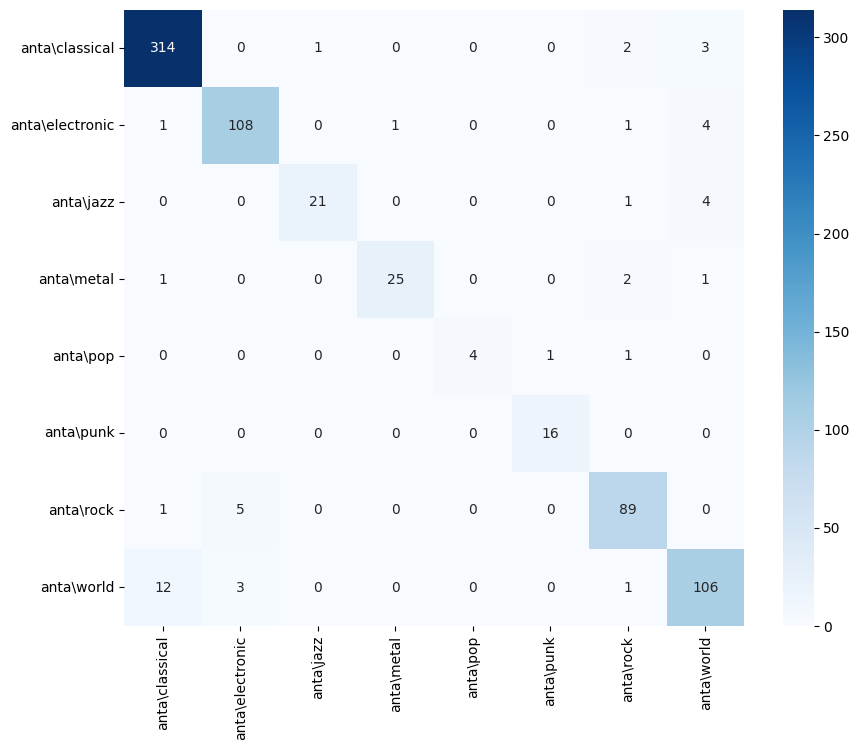

In [12]:
y_pred = model.predict(X_test)
genre_labels = data["mapping"]
confusion = confusion_matrix(y_test, y_pred.argmax(axis=1))
print('Confusion Matrix:')

plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, cmap='Blues', fmt='g', xticklabels=genre_labels, yticklabels=genre_labels)

In [13]:
print('Classification Report')

print(classification_report(y_test, y_pred.argmax(axis=1), target_names=genre_labels))

Classification Report
                 precision    recall  f1-score   support

 anta\classical       0.95      0.98      0.97       320
anta\electronic       0.93      0.94      0.94       115
      anta\jazz       0.95      0.81      0.88        26
     anta\metal       0.96      0.86      0.91        29
       anta\pop       1.00      0.67      0.80         6
      anta\punk       0.94      1.00      0.97        16
      anta\rock       0.92      0.94      0.93        95
     anta\world       0.90      0.87      0.88       122

       accuracy                           0.94       729
      macro avg       0.94      0.88      0.91       729
   weighted avg       0.94      0.94      0.94       729

